# Chapter 4. Learning neural network

learning: 훈련 데이터로부터 가중치 매개변수의 최적값을 자동으로 획득하는 것

perceptron convergence theorem: 선형 분리 가능 문제는 유한번의 학습을 통해 풀 수 있다

규칙을 '사람'이 만드는 방식에서 '기계'가 데이터로부터 배우는 방식으로의 패러다임 전환<br>
input -> 사람이 생각한 알고리즘 -> output<br>
input -> 사람이 생각한 특징 -> 기계학습(SVM,KNN,...)(사람 개입 x) -> output<br>
input -> 신경망(딥러닝)(사람 개입 x) -> output<br><br>
두 번째 접근 방식에서는 특징을 사람이 설계했지만, 신경망은 이미지에 포함된 중요 특징까지도 '기계'가 직접 학습하게 된다. <br>
딥러닝을 end-to-end machine learning (종단간 기계학습)이라고도 합니다. 여기서 종단간은 '처음부터 끝까지'라는 의미.<br>
신경망의 이점은 모든 문제를 같은 맥락에서 풀 수 있다는 점에 있다. 즉 신경망은 모든 문제를 주어진 데이터 그대로를 데이터로 활용해 'end-to-end'로 학습할 수 있다. 

In [78]:
import sys,os
%matplotlib notebook
import matplotlib.pylab as plt
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

오버피팅: 한 데이터셋에만 지나치게 최적화된 상태<br>
손실함수: 최적의 매개 변수값을 탐색하기 위해 학습중인 모델의 성능을 나타내는 지표, 일반적으로 mean squared error, cross entropy error 사용<br>
cross entropy error 의 경우 정답일 때의 출력만 전체 오차에 반영된다. 

In [2]:
def mean_squared_error(y,t):
    return 0.5*np.sum((y-t)**2)

In [3]:
def cross_entropy_error(y,t):
    return -np.sum(t*np.log(y+1e-7))

1e-7을 더해주는 이유는 log 함수에 0을 입력하면 -inf가 되므로 계산 진행이 안되기 때문

빅데이터의 경우 이를 대상으로 일일이 손실 함수를 계산하는 것은 시간이 오래 걸린다. 이런 경우 데이터 일부를 추려 전체의 근사치로 이용할 수 있다.<Br>
이 일부를 mini-batch라 한다. 가령 6만 장의 훈련 데이터 중 100장을 무작위로 뽑아 그 100장만 사용하여 학습하는 것. 이러한 학습 방법을 미니배치 학습 이라한다.<br>


In [6]:
(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,flatten=True,one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [8]:
# numpy random choice
train_size=x_train.shape[0]
batch_size=10
batch_mask=np.random.choice(train_size,batch_size)
x_batch=x_train[batch_mask]
t_batch=t_train[batch_mask]
print(x_batch.shape)
print(t_batch.shape)

(10, 784)
(10, 10)


In [9]:
def cross_entropy_error(y,t):
    if y.ndim==1:
        t=t.reshape(1,t.size)
        y=y.reshape(1,y.size)
    batch_size=y.shape[0]
    return -np.sum(t*np.log(y+1e-7))/batch_size
    # when 'one_hot_label=False' case, represented as real number label
    # return -np.sum(np.log(y[np.arange(batch_size),t]+1e-7))/batch_size

신경망을 학습할 때 정확도를 지표로 삼아서는 안 된다. 정확도를 지표로 하면 매개변수의 미분이 대부분의 장소에서 0이 되기 때문이다. <br>
100장 중 32장을 올바로 인식한다하면 정확도는 32%이다. 정확도를 지표로 삼으면 가중치 매개변수를 조금 바꾼다 해도 정확도가 32%로 개선되지 않거나 혹은 33%, 34% 와 같이 불연속적인 값으로 바뀌게 될 것이다. <br>
반면 손실함수를 지표로 삼으면 이 값은 연속적으로 변화하게 된다. <br>
이는 계단함수를 활성 함수로 사용하지 않는 이유와도 비슷하다. 계단 함수의 미분은 대부분 0이기 때문에 신경망 학습이 잘 이루어지지 않게 된다. <br>
계단 함수는 한순간만 변화를 일으키지만 시그모이드는 연속적으로 변하고 곡선의 기울기도 연속적으로 변하여 어느 곳이라도 미분값이 0이 되지 않는다. <br>
이는 신경망 학습에서 중요한 성질로 기울기가 0이 되지 않는 덕분에 신경망이 올바르게 학습할 수 있다. 

In [11]:
def numerical_diff(f,x):
    h=1e-4
    return (f(x+h)-f(x-h))/(2*h)

위의 미분은 아주 작은 차분으로 미분하는 수치 미분. 오차를 포함한다. <br>
한편 수식을 직접 미분하여 전개하는 방식을 해석적 (analytic)으로 미분하다 라고 한다. 오차를 포함하지 않는다. 

In [15]:
def numerical_gradient(f,x):
    h=1e-4
    grad=np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val=x[idx]
        x[idx]=tmp_val+h
        fxh1=f(x)
        x[idx]=tmp_val-h
        fxh2=f(x)
        
        grad[idx]=(fxh1-fxh2)/(2*h)
        x[idx]=tmp_val
    return grad
    
def gradient_descent(f,init_x,lr=0.01,step_num=100):
    x=init_x
    for i in range(step_num):
        grad=numerical_gradient(f,x)
        x-=lr*grad
    return x

In [16]:
def function_2(x):
    return x[0]**2+x[1]**2
init_x=np.array([-3.0,4.0])
gradient_descent(function_2,init_x=init_x,lr=0.1,step_num=100)

array([ -6.11110793e-10,   8.14814391e-10])

극솟값, 최솟값, 안장점에서 기울기가 0. 안장점은 어느 방향에서 보면 극댓값이고 다른 방향에서 보면 극솟값이 되는 점이다. <br>
따라서 경사법은 기울기 0 인 장소를 찾아내지만 그것이 반드시 최솟값이라 할 수 없다. <br>
또 복잡하고 찌그러진 모양의 함수면 평평한 곳으로 파고들면서 plateau 이라 하는 학습이 거의 진행되지 않는 정체기에 빠질 수 있다. 

학습률을 적절히 선택하는 것은 매우 중요하며 학습률과 같은 매개변수를 hyper parameter라 한다. <br>
신경망의 가중치 파라미터는 훈련 데이터와 학습 알고리즘에 의해 '자동'으로 획득되는 매개변수인 반면, 학습률 같은 하이퍼파라미터는 사람이 직접 설정해야하는 매개변수이다. 

In [50]:
from common.functions import *
from common.gradient import numerical_gradient

In [21]:
class simpleNet:
    def __init__(self):
        self.W=np.random.randn(2,3)
    
    def predict(self,x):
        return np.dot(x,self.W)
    
    def loss(self,x,t):
        z=self.predict(x)
        y=softmax(z)
        return cross_entropy_error(y,t)
    

In [48]:
net=simpleNet()
print(net.W)
x=np.array([0.6,0.9])
t=np.array([0,0,1])
p=net.predict(x)
print(p)
np.argmax(p)
net.loss(x,t)


[[-1.6146145  -0.49838017  0.28661731]
 [-0.87538339 -0.63701992 -0.11220922]]
[-1.75661374 -0.87234603  0.07098209]


0.43833840784082612

In [49]:
def f(W):
    return net.loss(x,t)
dW=numerical_gradient(f,net.W)
print(dW)

[[ 0.06223983  0.15069574 -0.21293557]
 [ 0.09335974  0.22604361 -0.31940335]]


경사 하강법으로 매개변수를 갱신할 때 데이터를 미니배치로 무작위로 선정하면서 갱신하는 것을 확률적 경사 하강법(SGD) 라 한다. <br>
확률적으로 무작위로 골라낸 데이터 에 대해 수행하는 경사 하강법이란 의미다. 

In [72]:
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        self.params={}
        self.params['W1']=weight_init_std*np.random.randn(input_size,hidden_size)
        self.params['b1']=np.zeros(hidden_size)
        self.params['W2']=weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b2']=np.zeros(output_size)
    def predict(self,x):
        W1,W2=self.params['W1'],self.params['W2']
        b1,b2=self.params['b1'],self.params['b2']
        a1=np.dot(x,W1)+b1
        z1=sigmoid(a1)
        a2=np.dot(z1,W2)+b2
        y=sigmoid(a2)
        return y
    def loss(self,x,t):
        y=self.predict(x)
        return cross_entropy_error(y,t)
    def accuracy(self,x,t):
        y=self.predict(x)
        y=np.argmax(y,axis=1)
        t=np.argmax(t,axis=1)
        
        accuracy=np.sum(y==t)/float(x.shape[0])
        return accuracy
    def numerical_gradient(self,x,t):
        loss_W=lambda W:self.loss(x,t)
        grads={}
        grads['W1']=numerical_gradient(loss_W,self.params['W1'])
        grads['b1']=numerical_gradient(loss_W,self.params['b1'])
        grads['W2']=numerical_gradient(loss_W,self.params['W2'])
        grads['b2']=numerical_gradient(loss_W,self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

여기서의 numerical_gradient는 수치 미분 방식으로 기울기를 계산한다. 다음 장에서 back propagation 방법(여기에서의 gradient 함수)으로 기울기 계산을 수행하는 기법이 나온다. <br>
back propagation으로 수치 미분과 거의 같은 결과를 훨씬 빠르게 구할 수 있다. <br>
신경망 학습은 오랜 시간이 걸리니 numerical gradient보다 back propagation 을 이용하는 것이 좋다.

In [66]:
net=TwoLayerNet(input_size=784,hidden_size=100,output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)


(784, 100)
(100,)
(100, 10)
(10,)


In [67]:
x=np.random.rand(100,784)
t=np.random.rand(100,10)
grads=net.numerical_gradient(x,t)
print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)
#y=net.predict(x)

(784, 100)
(100,)
(100, 10)
(10,)


---
## mini-batch learning 구현하기

1 epoch = 학습에서 훈련 데이터를 모두 소진했을 때의 횟수<br>
ex. 훈련 데이터 10,000개를 100개의 미니배치로 학습할 경우, SGD을 100회 반복하면 모든 훈련 데이터를 '소진'하게 된다. 이 경우 100회가 1에폭이다. 

In [73]:
## np, load_mnist, TwoLayerNet 필요
(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,flatten=True,one_hot_label=True)
train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

# hyperparam
iters_num=10000
train_size=x_train.shape[0]
batch_size=100
learning_rate=0.1

# 1에폭당 반복 수
iter_per_epoch=max(train_size/batch_size,1)

network=TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask=np.random.choice(train_size,batch_size)
    x_batch=x_train[batch_mask]
    t_batch=t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch,t_batch)
    grad = network.gradient(x_batch,t_batch)
    
    # 매개변수 갱신
    for key in ('W1','b1','W2','b2'):
        network.params[key]-=learning_rate*grad[key]
        
    # 학습 경과 기록
    loss=network.loss(x_batch,t_batch)
    train_loss_list.append(loss)
    
    if i% iter_per_epoch==0:
        train_acc=network.accuracy(x_train,t_train)
        test_acc=network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc : "+ str(train_acc*100.)+"%, "+str(test_acc*100.)+"%")

train acc, test acc : 11.2366666667%, 11.35
train acc, test acc : 79.9316666667%, 80.38
train acc, test acc : 87.7583333333%, 87.94
train acc, test acc : 89.8566666667%, 89.91
train acc, test acc : 90.7983333333%, 90.91
train acc, test acc : 91.375%, 91.64
train acc, test acc : 91.8783333333%, 92.28
train acc, test acc : 92.3483333333%, 92.57
train acc, test acc : 92.725%, 92.74
train acc, test acc : 93.05%, 93.11
train acc, test acc : 93.3166666667%, 93.43
train acc, test acc : 93.6766666667%, 93.58
train acc, test acc : 93.9733333333%, 93.87
train acc, test acc : 94.2183333333%, 94.3
train acc, test acc : 94.375%, 94.39
train acc, test acc : 94.6316666667%, 94.59
train acc, test acc : 94.765%, 94.71


<IPython.core.display.Javascript object>


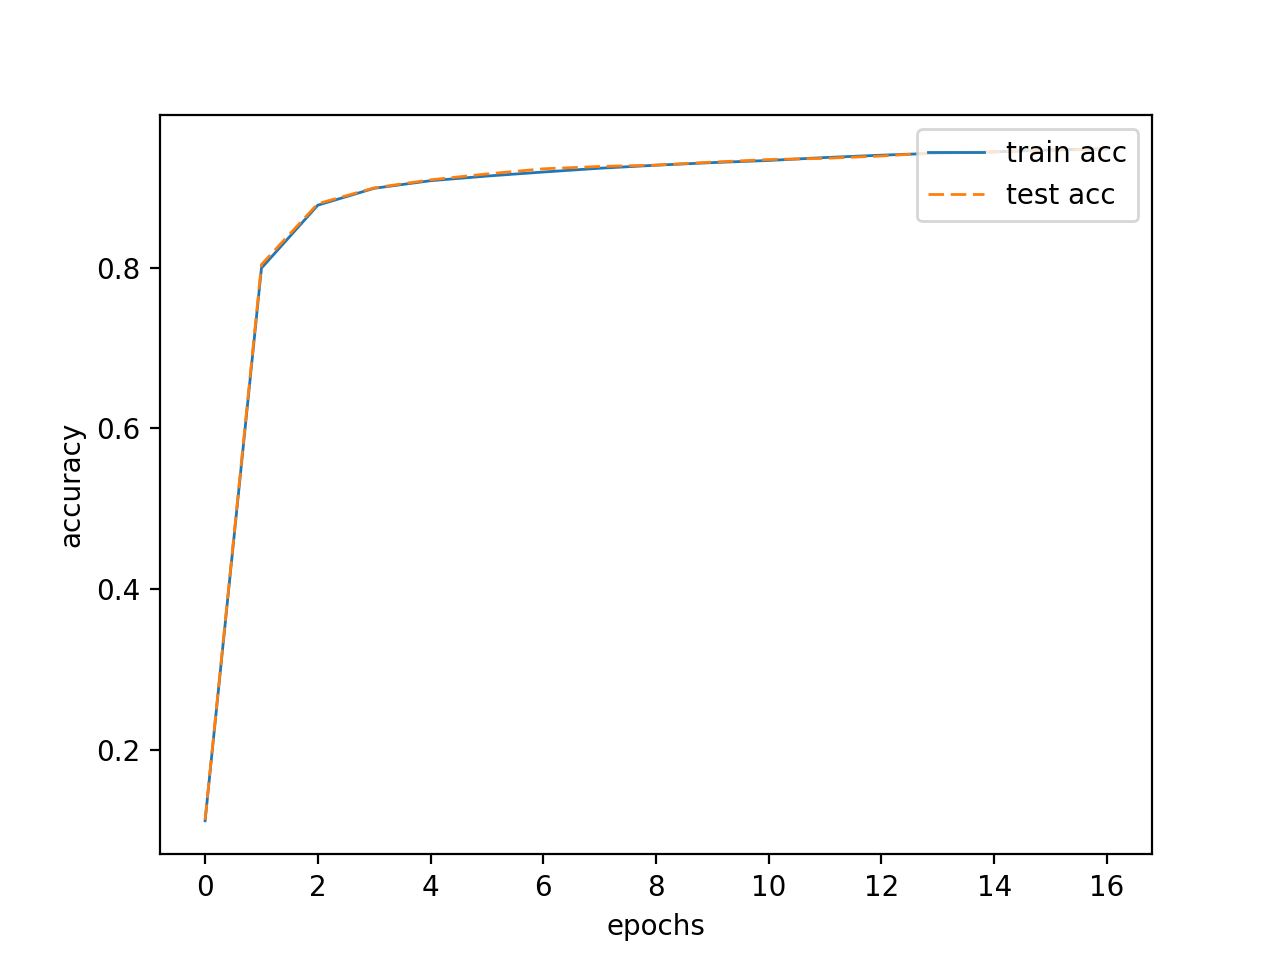

In [95]:
line1,=plt.plot(range(17),train_acc_list[:17],label='train acc',linewidth=1)
line2,=plt.plot(range(17),test_acc_list[:17],label='test acc',linestyle='--',linewidth=1)
legend = plt.legend(handles=[line1,line2], loc=1)
plt.xlabel('epochs')
plt.ylabel('accuracy')

4장 정리:
    * 신경망 학습은 손실 함수를 지표로, 손실 함수의 값이 작아지는 방향으로 가중치 매개변수를 갱신한다.
    * 가중치 매개변수 갱신 시 가중치 매개변수의 기울기를 이요하고, 기울어진 방향으로 가중치의 값을 갱신하는 작업을 반복한다.
    * 아주 작은 값을 주었을때의 차분으로 미분하는 것을 수치 미분이라 한다.
    * 수치 미분을 이용한 계산에는 시간이 걸리지만 구현은 간단하다. 5장에서 설명할 back propagation 방법은 기울기를 보다 고속으로 구할 수 있다. 